In [2]:
import pandas as pd
import numpy as np

# 데이터 전처리 (data_preprocessing.ipynb)

In [13]:
# Read Data
df = pd.read_excel("../data/train.xlsx")

In [14]:
# 년/월/일 분리(split) + 요일(Weekday) 추가
def split_date(df):
    # Normalize Date
    df['year'] = (df['일자'] / 10000).astype(int)
    df['month'] = (df['일자'] % 10000 / 100).astype(int)
    df['day'] = (df['일자'] % 100).astype(int)
    df['weekday'] = pd.to_datetime(df['일자'], format = '%Y%m%d').dt.dayofweek
    df.drop(['일자'], axis=1, inplace=True)

In [16]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d


In [22]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]

In [48]:
# 식사명 변환 (one-hot)
def convert_ont_hot(df):
    df = df.join(pd.get_dummies(df['식사명'], prefix='식사명'))
    df.drop(['식사명'], axis=1, inplace=True)
    return df

In [49]:
# 식사내용 변환 (Bag-of-Word)
from sklearn.feature_extraction.text import CountVectorizer
def tokenize(text):
        return text.split(',')
def convert_bow(df):
    vectorizer = CountVectorizer(tokenizer=tokenize)
    bow = vectorizer.fit_transform(df['식사내용']).toarray()
    df = df.join(pd.DataFrame(bow, columns=vectorizer.get_feature_names()))
    df.drop(['식사내용'], axis=1, inplace=True)
    return df

In [30]:
# Read Data
df = pd.read_excel("../data/train.xlsx")

In [31]:
# Date
split_date(df)
add_lunar_date(df)

# Date Normalization
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [50]:
# convert 식사명 to one-hot
df = convert_ont_hot(df)

# convert 식사내용 to Bag-of-Word Vector
df = convert_bow(df)

In [54]:
print("Number of Columns =", len(df.columns))
df.head()

Number of Columns = 1889


,수량,year,lunar_year,month_sin,month_cos,lunar_month_sin,lunar_month_cos,day_sin,day_cos,lunar_ay_sin,...,휘),흑미밥,흑미밥(현장),흑임자밥,흑임자죽,흑콩견과류조림,흑콩밥,흑콩조림,흰죽,흰콩곤약조림
0,37.472924,0.0,0.0,1.0,6.123234e-17,0.5,0.866025,0.201299,0.979530,-0.394356,...,0,0,0,0,0,0,0,0,0,0
1,19.566787,0.0,0.0,1.0,6.123234e-17,0.5,0.866025,0.201299,0.979530,-0.394356,...,0,0,0,0,0,0,0,0,0,0
2,31.191336,0.0,0.0,1.0,6.123234e-17,0.5,0.866025,0.201299,0.979530,-0.394356,...,0,0,0,0,0,0,0,0,0,0
3,36.101083,0.0,0.0,1.0,6.123234e-17,0.5,0.866025,0.394356,0.918958,-0.201299,...,0,0,0,0,0,0,0,0,0,0
4,21.949458,0.0,0.0,1.0,6.123234e-17,0.5,0.866025,0.394356,0.918958,-0.201299,...,0,0,0,0,0,0,0,0,0,0


# Modeling

1. Random Forest
2. XGBoost

## 0. Prepare train & test

#### 1) Split train and test(validation) set by 8 to 2

In [55]:
from sklearn.model_selection import train_test_split
train_df, dev_df = train_test_split(df, test_size=0.2, random_state=10)
print(train_df.shape)
print(dev_df.shape)

(16008, 1889)
(4002, 1889)


In [56]:
train_y = train_df['수량']
train_x = train_df.drop(['수량'], axis=1)
dev_y = dev_df['수량']
dev_x = dev_df.drop(['수량'], axis=1)

#### 2) train, predict, evaluation function (반복적으로 사용되는 코드이므로)

In [57]:
from sklearn.metrics import mean_squared_error
import math

def train_and_predict(model, train_x, train_y, dev_x):
    model.fit(train_x, train_y)
    return model.predict(dev_x)

def evaluate(predict_y, actual_y):
    rmse = math.sqrt(mean_squared_error(actual_y, predict_y))
    print('RMSE :', round(np.mean(rmse), 4))

## 1. Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 100, random_state = 10)

In [59]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 6.6843


## 2. XGBoost

In [61]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=150, 
                         learning_rate=0.05, 
                         max_depth=11,
                         colsample_bytree=0.9,
                         gamma=0.4,
                         min_child_weight=7,
                         subsample=0.9,
                         reg_alpha=0.1,
                         seed=10)

CPU times: user 20.1 ms, sys: 22.1 ms, total: 42.2 ms
Wall time: 159 ms


/Users/Joohong/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
%%time
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 6.4987
CPU times: user 6min 29s, sys: 1.86 s, total: 6min 31s
Wall time: 6min 35s


AttributeError: Unknown property max_num_features

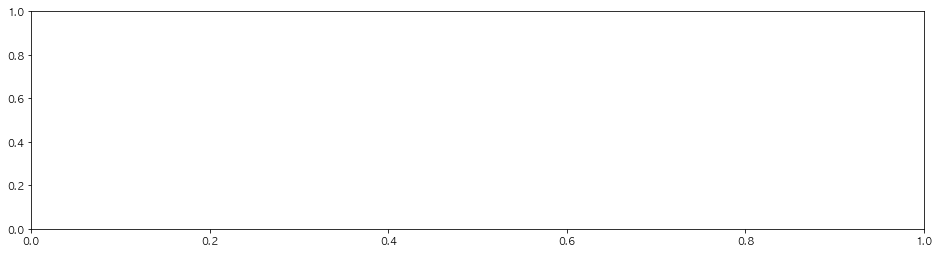

In [69]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

plt.rcParams['figure.figsize'] = (16,4)
plt.rcParams['font.family'] = 'AppleGothic'

xgb.plot_importance(model, max_num_features=10)

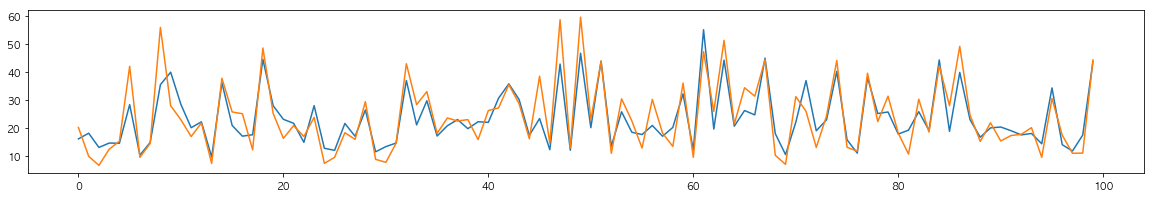

In [70]:
plt.rcParams["figure.figsize"] = (20,3)
index = 500

plt.plot(pred[index:index+100])
plt.plot(dev_y.values[index:index+100])